In [24]:
import os
import site
import sqlite3
import sys
import warnings
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm
from yaml import dump, load, safe_load

In [2]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [3]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [4]:
sys.path.append("../../sql")
import queries

In [5]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [6]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [7]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [101]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
columns = df.columns.tolist()
# df.head(5)

In [104]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [25]:
# df_diff = df_rsm.diff(periods=12).dropna()

df_diff = df_rsm.copy()
for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

# df_diff.head(12)2)

In [35]:
df_diff_r = df_diff[:240]
# df_diff_r

In [73]:
def arima_model(series, p=0, d=0, q=0, s=0, num_fc=1, summary=False, forecast=False):
    """
    Takes an irradiance related series and fits an ARIMA(p, d, q) model.
    Returns a number of forecasts as specified by num_forecasts or
    a fit model is returned if forecast is not set.
    """
    
    start = len(series)
    end = start + num_fc - 1

    model = ARIMA(
        series,
        order=(p, d, p),
        seasonal_order=(0, 0, 0, s),
        enforce_stationarity=True,
        trend="n",
        # freq="M",
    ).fit()

    if summary:
        print(model.summary())
        
    if forecast:
        forecasts = model.predict(start=start, end=end)
        return forecast

    return model

In [74]:
model = arima_model(df_rsm[columns[1]], p=1, d=1, q=1, s=0, summary=True)

                               SARIMAX Results                                
Dep. Variable:                    DNI   No. Observations:                  276
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1488.735
Date:                Sun, 25 Jul 2021   AIC                           2983.469
Time:                        14:09:22   BIC                           2994.320
Sample:                    01-31-1998   HQIC                          2987.824
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8357      0.144     -5.822      0.000      -1.117      -0.554
ma.L1          0.7465      0.173      4.314      0.000       0.407       1.086
sigma2      2948.5463    276.527     10.663      0.0

/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [77]:
forecasts = arima_model(df_rsm.iloc[:240][columns[1]], p=1, d=1, q=1, num_fc=1, forecast=True)
# forecasts

/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


TypeError: cannot concatenate object of type '<class 'bool'>'; only Series and DataFrame objs are valid

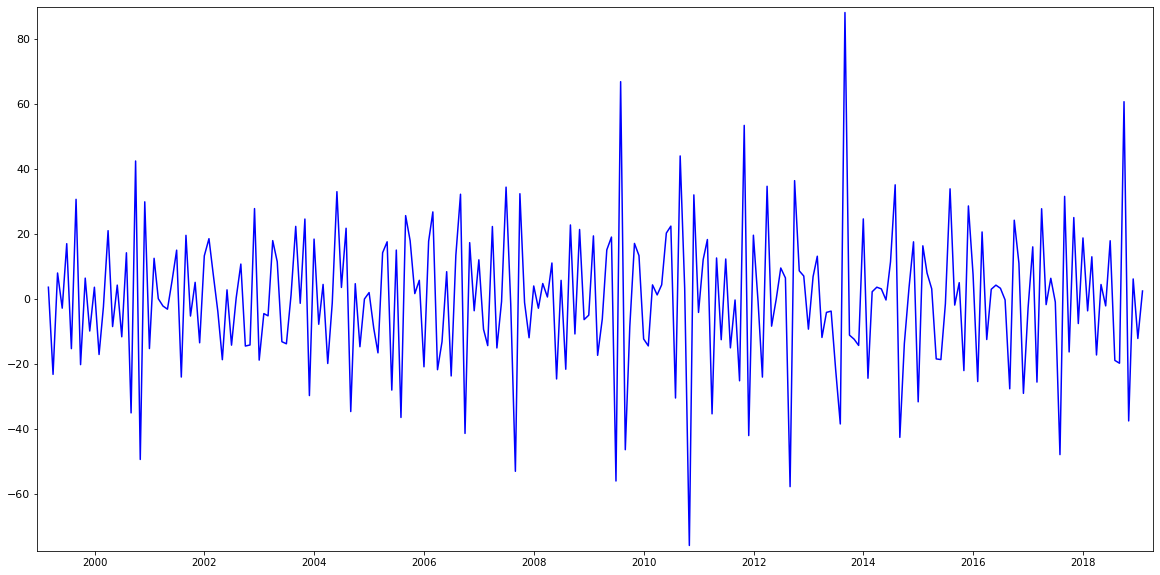

In [78]:
actual = df_rsm.iloc[240:][columns[0]]

rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_diff_r[columns[0]], label="Original", color="blue")
ax.plot(df_diff_r[columns[0]][-1:].append(forecasts), label="Forecasted", color="orange")
ax.plot(df_diff_r[columns[0]][-1:].append(actual), label="Actual", color="green")

ax.set_xlabel("Month")

ax.set_title(
    f"Differenced Monthly {columns[0]} values\n" + f"{len(forecasts)}-month Forecast, RMSE = {rmse: .2f}"
)

ax.grid()
ax.legend();

In [70]:
df_diff[columns[0]][252:]

date_time
2020-01-31     2.090054
2020-02-29     3.837438
2020-03-31    -3.399194
2020-04-30     0.970833
2020-05-31    27.194892
2020-06-30     0.436111
2020-07-31    11.116935
2020-08-31   -60.536290
2020-09-30   -94.718056
2020-10-31   -39.279570
2020-11-30     8.327778
2020-12-31    11.075269
Name: Clearsky_DNI, dtype: float64

In [69]:
actual

date_time
2020-01-31     2.090054
2020-02-29     3.837438
2020-03-31    -3.399194
2020-04-30     0.970833
2020-05-31    27.194892
2020-06-30     0.436111
2020-07-31    11.116935
2020-08-31   -60.536290
2020-09-30   -94.718056
2020-10-31   -39.279570
2020-11-30     8.327778
2020-12-31    11.075269
Name: Clearsky_DNI, dtype: float64